# AirBnB : Part 2, Exploratory Data Analysis

In [29]:
%matplotlib inline 

import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.feature_selection import SelectKBest,VarianceThreshold
from sklearn.feature_selection import chi2


from sklearn.preprocessing import MinMaxScaler,LabelEncoder

from utils import rstr,distance

airBColor= '#ff5a5f'
airBColor2= '#008489'

In [2]:
df_listing = pd.read_csv('../../data/listing_cleansed.csv')
print df_listing.shape

(9208, 220)


### Filter on numeric features

In [3]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_listing = df_listing.select_dtypes(include=numerics)

### Remove listing with no reviews

In [4]:
df_listing = df_listing[~df_listing.last_review.isnull()]

In [5]:
df_listing.shape

(7703, 205)

### Fill missing data

In [6]:
df_missing_data = pd.DataFrame(df_listing.isnull().sum()/len(df_listing)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent
host_response_time,28.002077
host_response_rate,28.002077
review_scores_value,1.713618
review_scores_checkin,1.687654
review_scores_location,1.661690
review_scores_accuracy,1.622744
review_scores_communication,1.583799
review_scores_cleanliness,1.544853
review_scores_rating,1.363105
bathrooms,0.337531


### Replace abnormal values and missing data

In [7]:
df_listing.loc[df_listing['maximum_nights'] > 365, 'maximum_nights'] = 365

In [8]:
columns_fill_na_with_mean = df_missing_data.index
df_listing[columns_fill_na_with_mean]= df_listing[columns_fill_na_with_mean].fillna(df_listing[columns_fill_na_with_mean].mean())

In [9]:
df_missing_data = pd.DataFrame(df_listing.isnull().sum()/len(df_listing)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent


### Add distance to Berlin center

In [10]:
coord_brandenburg_tor = (52.516849,13.377661)
def distance_highlight(x):
    return distance(coord_brandenburg_tor,x)

In [11]:
df_listing['coordinate']=list(zip(df_listing.latitude, df_listing.longitude))
df_listing['distance_brandenburg_tor'] = df_listing['coordinate'].apply(distance_highlight)
df_listing.distance_brandenburg_tor = MinMaxScaler().fit_transform(df_listing.distance_brandenburg_tor)
df_listing.drop('coordinate',axis=1,inplace=True)

/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


### Add target label

In [12]:
TARGET = 'is_multihost'

In [13]:
df_listing['listings_per_host']=df_listing.groupby(["host_id"])["listing_id"].transform("count")
df_listing[TARGET]=( df_listing.listings_per_host>1)*1

In [14]:
y = df_listing[TARGET]
X = df_listing.drop([TARGET,'listing_id','host_id'],axis=1)

In [15]:
print X.shape,y.shape

(7703, 205) (7703,)


In [22]:
# Create and fit selector
selector = SelectKBest(chi2, k=5)
selector.fit(X, y)
# Get idxs of columns to keep
idxs_selected = selector.get_support(indices=True)
print idxs_selected
# Create new dataframe with only desired columns, or overwrite existing
features_dataframe_new = X[X.columns[idxs_selected]]

[ 18  22  23  25 199]


In [23]:
features_dataframe_new['is_multihost']=y

/home/ramon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [24]:
good_features = features_dataframe_new.columns.tolist()
good_features.remove('is_multihost')

In [25]:
good_features

['maximum_nights',
 'availability_365',
 'number_of_reviews',
 'last_review',
 'availability_365_previous_month']

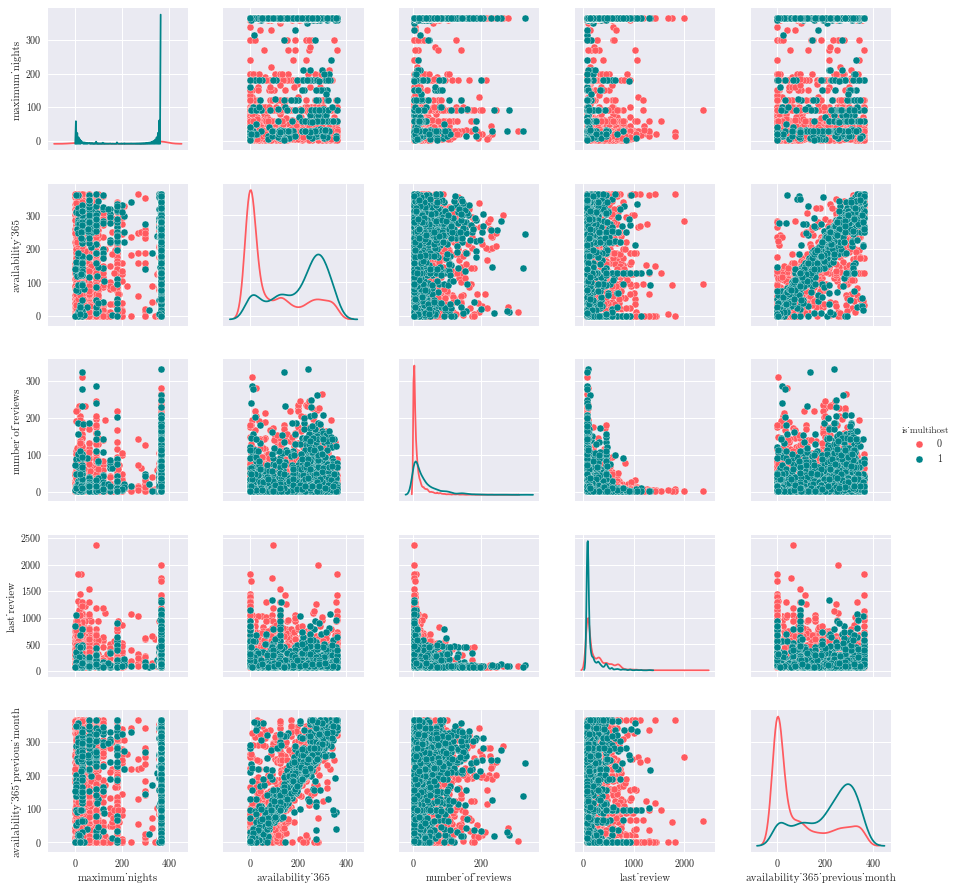

In [31]:
sns.set_style("darkgrid", { 'font.family': ['cmr10'],})
sns.pairplot(features_dataframe_new, hue="is_multihost",vars=good_features,diag_kind="kde",palette={0:airBColor,1:airBColor2})